# Imports and functions

In [2]:
import h5py
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
import geopandas
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from pathlib import Path
import matplotlib.cm as cm
import sys
import glob
import netCDF4
import os
import tqdm
import geopandas as gpd
from PIL import Image
import matplotlib.pyplot as plt
import odc.geo.xr
import shapely
from shapely.geometry import Point

In [3]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)

In [4]:
## Function to read ATL10 data
def read_atl10(filename):
    print('processing',filename)
    # Create a list for saving ATL10 beam track data
    track = []

    with h5py.File(filename,'r') as f:

        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]

        if orient == 0:
            strong_beams = [f"gt{i}l" for i in [1, 2, 3]]
        elif orient == 1:
            strong_beams = [f"gt{i}r" for i in [1, 2, 3]]
        else:
            strong_beams = []

        for beam in strong_beams:
            if beam in f.keys():
                lat = f[beam]['freeboard_segment/latitude'][:]
                lon = f[beam]['freeboard_segment/longitude'][:]
                # Funky way to create a timestamp from the bytes
                time = pd.to_datetime(f['ancillary_data']['data_end_utc'][0][0:10].decode("utf-8"))
                seg_x = f[beam]['freeboard_segment/seg_dist_x'][:] / 1000 # (m to km)
                seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][:]
                fb = f[beam]['freeboard_segment/beam_fb_height'][:]
                surface_type = f[beam]['freeboard_segment/heights/height_segment_type'][:]
                fb[fb>100] = np.nan

                df = pd.DataFrame({'lat': lat, 'lon': lon, 'time':time, 'seg_x': seg_x, 'seg_len': seg_len,
                                  'freeboard': fb, 'stype': surface_type})

                df['beam'] = beam
                df = df.dropna().reset_index(drop = True)

                gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

                # Assign crs information into geodatafraem
                gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

                track.append(gdf)
    track = pd.concat(track)
    
            
    return track

# Create xarray / netcdf from h5 files

In [5]:
# Load and sort filelist by time

filedict = {}
# Path to IS2 H5 files
path = '/g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/'
print("Finding files")
# The "02" just matches the sea ice product
for file in Path(path).rglob('*ATL10-02*.h5'):
    time = pd.to_datetime(os.path.splitext(os.path.basename(file)[9:17])[0])
    filedict[time] = file
    # filelist.append(file)
    
# The index numbers in the following line are used to sort the file list by date, they made need adjusting depending on which product you use.
# filelist = sorted(filelist, key=lambda i: int(os.path.splitext(os.path.basename(i)[9:17])[0]))
# print(f"Processing {len(filelist)} files")

# extract dimensions from top layer of h5 file
# dims = xr.open_dataset(filelist[0])

Finding files


In [7]:
months = {}

for date, data in filedict.items():
    yearmonth = date.strftime('%Y-%m')
    # print(yearmonth, data)
    # Update sum if already tracking, otherwise create new entry in dictionary
    # months[yearmonth] = data if yearmonth in months else total
    if yearmonth in months.keys():
        months[yearmonth].append(data)
    else:
        months[yearmonth] = [data]

# print(months)

In [9]:
# with h5py.File('/g/data/gv90/P6_data/ICESat2/ATL10_2/ATL10-02_20221229201203_01421801_006_01.h5','r') as f:
#     print(f.keys())
#     if 'gt1r' in f.keys():
#         print("success")

In [10]:
fb = []

for key, value in months.items():
    print("processing", key)
    one_month = pd.concat([read_atl10(file) for file in value])
    fb.append(one_month)   

processing 2018-10
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181022153002_03670101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181018043818_02990101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181019164659_03220101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181014154641_02450101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181024174719_03990101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181026165601_04290101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181029043901_04670101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181031162205_05050101_006_02.h5
processing /g/data/gv90/P6_data/NSIDC/ICESat2/YOUNG_ATL10_ONEMONTH/ATL10-02_20181027163022_04440101_0

In [12]:
# We are only grabbing one month here and converting it to csv
fb[1].to_csv("/g/data/jk72/sc0554/floes/beam_fb_height_young_data_201811.csv")


# Attempts at plotting

In [13]:
fb[0]

,lat,lon,time,seg_x,seg_len,freeboard,stype,beam,geometry
0,-63.492051,-20.252864,2018-10-22,33065.223736,117.943649,0.068144,1,gt1r,POINT (-20.25286 -63.49205)
1,-63.491717,-20.252944,2018-10-22,33065.261200,94.964478,0.053330,1,gt1r,POINT (-20.25294 -63.49172)
2,-63.475735,-20.256794,2018-10-22,33067.053011,120.722992,0.190082,1,gt1r,POINT (-20.25679 -63.47573)
3,-63.475612,-20.256824,2018-10-22,33067.066734,68.869995,0.134871,1,gt1r,POINT (-20.25682 -63.47561)
4,-63.475475,-20.256858,2018-10-22,33067.082180,63.111557,0.075509,1,gt1r,POINT (-20.25686 -63.47547)
...,...,...,...,...,...,...,...,...,...
7428,-65.792131,-54.561239,2018-10-20,32806.436742,19.709740,0.861428,1,gt3r,POINT (-54.56124 -65.79213)
7429,-65.792040,-54.561265,2018-10-20,32806.446917,21.089243,1.032612,1,gt3r,POINT (-54.56126 -65.79204)
7430,-65.791934,-54.561295,2018-10-20,32806.458847,21.766788,1.043087,1,gt3r,POINT (-54.56129 -65.79193)
7431,-65.791844,-54.561320,2018-10-20,32806.468909,20.342913,1.020329,1,gt3r,POINT (-54.56132 -65.79184)


In [ ]:
from shapely.geometry import LineString
df['line'] = df.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column

<AxesSubplot:xlabel='delta_time'>

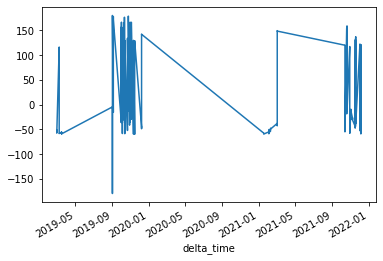

In [43]:
gfs['longitude'].plot()

In [8]:
filtered = gfs[(-60 < gfs.longitude) & (gfs.longitude < 0)]

In [24]:
# plot the polygon vectors
from ipyleaflet import Map, basemaps, GeoData, GeoJSON, LayerGroup, LayersControl, LegendControl, projections, Choropleth
from ipywidgets import Layout
import matplotlib.colors as mplcolors
import matplotlib.cm



colors=['red', 'yellow', 'green', 'orange']



def my_func(feature):
    print(feature['properties']['ID'])
    print('----')
    return {'color':colors[feature['properties']['ID']]}


#somewhere to show the results
spsLayout=Layout(width='600px', height='600px')
zoom = 0.85
center = [-70, 130]
map = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=center, zoom=zoom, crs=projections.EPSG3031, layout=spsLayout )
map.add_layer(GeoJSON(data=json.loads(gdf.to_json()), style_callback=my_func))

NameError: name 'json' is not defined

TypeError: 'LinearColormap' object is not subscriptable

In [27]:
import branca.colormap as cm
step = cm.StepColormap(['blue','red'],
                           vmin = int(filtered['beam_fb_height'].min()), vmax = int(filtered['beam_fb_height'].max()))
colors = step.to_linear()

colors

In [29]:
type(colors)

branca.colormap.LinearColormap

In [12]:
filtered['beam_fb_height']

delta_time
2021-12-03 12:36:36.904201696   NaN
2021-12-03 12:36:40.216043120   NaN
2021-12-03 12:36:40.970421856   NaN
2021-12-03 12:37:25.038129840   NaN
2021-12-03 12:37:30.286975072   NaN
                                 ..
2021-11-19 12:22:01.859174080   NaN
2021-11-19 12:22:06.153483472   NaN
2021-11-19 12:22:09.128888704   NaN
2021-11-19 12:22:16.058617792   NaN
2021-11-19 12:22:17.402330592   NaN
Name: beam_fb_height, Length: 21052, dtype: float32

In [9]:
geo_data = GeoData(geo_dataframe = filtered,
    style={'color': 'black', 'radius':4, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'ICESAT2')

# Create custom projection with bounds for Polar view WMS layer
POLAR3031 = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds =[[-2822131.5,-3057369.25],[3744213.75,3822194.25]]
)

graticule = WMSLayer(
    url='http://geos.polarview.aq/geoserver/wms',
    layers='polarview:graticuleS',
    format='image/png',
    transparent=True,
    attribution='Polarview',
    crs=POLAR3031
)

In [10]:
# Create map layer
spsLayout=Layout(width='800px', height='800px')
m = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=(-90, 0), zoom=1, crs=projections.EPSG3031, layout=spsLayout)
m.add_layer(geo_data)
m.add_layer(graticule)
m

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…